In [1]:
! pip install -U numpy matplotlib graphviz

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/b7/db/4d37359e2c9cf8bf071c08b8a6f7374648a5ab2e76e2e22e3b808f81d507/numpy-1.25.2-cp310-cp310-win_amd64.whl.metadata
  Using cached numpy-1.25.2-cp310-cp310-win_amd64.whl.metadata (5.7 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/ff/1f/2b83c7acf453318a80dc619e99fc30a663b2c1fb18be3d358a96addfecd9/matplotlib-3.7.2-cp310-cp310-win_amd64.whl.metadata
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/94/0a/5eb57dd395fade977786b2d2c98c2bee8234358794be44422fe58a719d42/contourpy-1.1.0-cp310-cp310-win_amd64.whl.metadata
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/1c/c6/408ee90eae2fd7ef85c5baaedfc8d533805f4c54fc6670dbde9539f1277b/fonttools-

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [4]:
f(3.0)

20.0

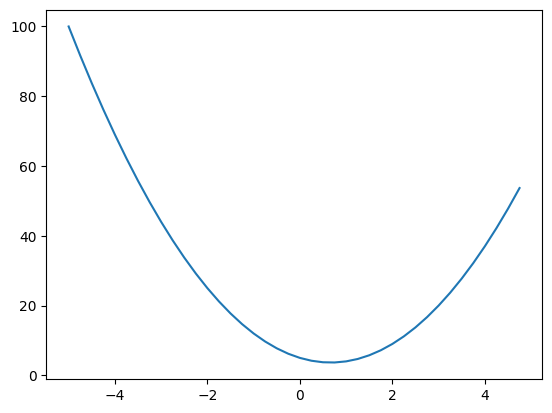

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [6]:
# Derivative
# Simple case
h = 0.000000000001
x = -3.0

print(f"f(x): {f(x)}")
print(f"f(x + h): {f(x + h)}")
print(f"(f(x + h) - f(x)) / h: {(f(x + h) - f(x)) / h}")

f(x): 44.0
f(x + h): 43.999999999978
(f(x + h) - f(x)) / h: -21.9984030991327


In [7]:
# Complex case
# Inputs
a = 2.0
b = -3.0
c = 10.0

# Function
d = a * b + c

d

4.0

In [8]:
def sloper(n):
    h = 0.0001

    # Inputs
    a = 2.0
    b = -3.0
    c = 10.0

    d1 = a * b + c
    if n == "a":
        a += h
    elif n == "b":
        b += h
    elif n == "c":
        c += h

    d2 = a * b + c

    print("d1: ", d1)
    print("d2: ", d2)
    print(f"slope with respect to {n}: ", (d2 - d1) / h)
    print()


sloper("a")
sloper("b")
sloper("c")

d1:  4.0
d2:  3.999699999999999
slope with respect to a:  -3.000000000010772

d1:  4.0
d2:  4.0002
slope with respect to b:  2.0000000000042206

d1:  4.0
d2:  4.0001
slope with respect to c:  0.9999999999976694



In [9]:
# Now let's start buiding micrograd
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None

        self._prev = set(_children)
        self._op = _op

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"^{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [10]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [11]:
# MLP

# Inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"

x2w2 = x2 * w2
x2w2.label = "x2w2"

tot = x1w1 + x2w2
tot.label = "tot"

n = tot + b
n.label = "n"

In [12]:
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = "o"
o.grad = 1.0

In [13]:
o.backward()

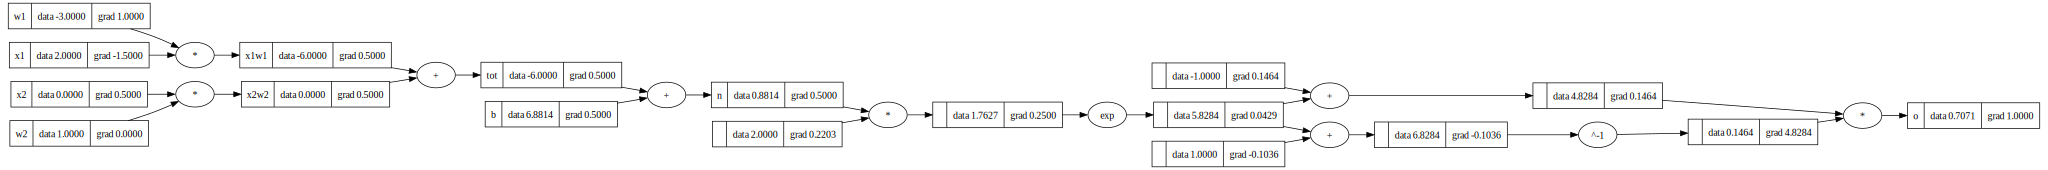

In [14]:
draw_dot(o)

Link to PyTorch implementation: https://colab.research.google.com/drive/1zqtpEa0hYVUAwd3YOTvLCKMdgeOW6bL9?usp=sharing

In [15]:
import random


class Neuron:
    def __init__(self, nin) -> None:
        self.w = [(Value(random.uniform(-1, 1))) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

n(x)

Value(data=-0.624824402333011)

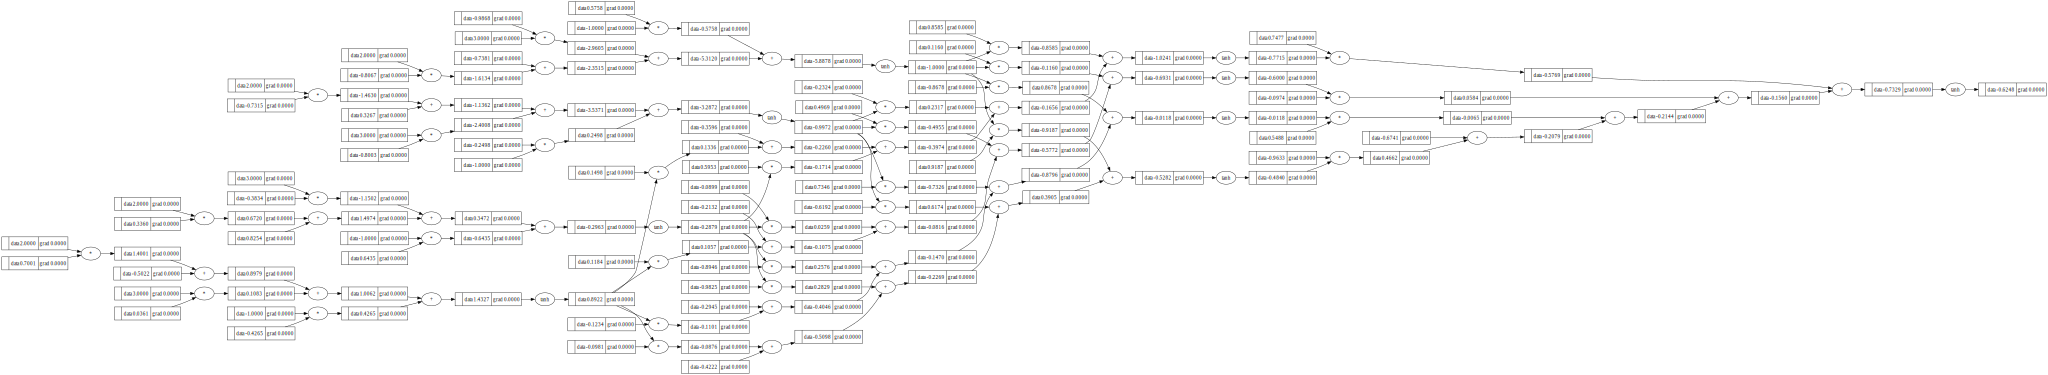

In [16]:
draw_dot(n(x))

In [17]:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0]

In [18]:
n.layers[0].neurons[0].w[0].data

0.7000583545112964

In [ ]:
n.layers[0].neurons[0].w[0].grad

0.0

In [19]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
        
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k,  loss.data)

0 5.531236214051956
1 4.993727892047243
2 4.5240671903286165
3 4.1423020105310835
4 3.833593368123499
5 3.5737639796122878
6 3.3414398098780986
7 3.123042319226938
8 2.912299650594801
9 2.7076003386164404
10 2.509616491752558
11 2.319833885289553
12 2.1397861586686164
13 1.9707009792984287
14 1.813372216677352
15 1.668153015934006
16 1.5350090116659905
17 1.4135965082789423
18 1.3033456258149179
19 1.2035373748781313


In [20]:
ypred

[Value(data=0.4725892503770426),
 Value(data=-0.4000338488120946),
 Value(data=-0.49696274578484595),
 Value(data=0.44109981717597246)]